# Elements of success in iOS's App Store
As of September 2018, there were approximately 2 million iOS apps available on the App Store. By looking at a sample of those, we'll ask the questions:

> Are there shared elements that contribute to **free** mobile application's *success*?

> Are there shared elements that contribute to **free** mobile application's *failure*?

### OBJECTIVE
By the end of this analysis we expect a graphical representation of the correlation between specific elements and the success/failure of the app. The **elements to be evaluated** are:
- App's genre in comparision to other genres
- App's size in bytes
- App's name characteristics

And the **success/failure** will be defined as a score considering:
- Absolute Rating Count
- Average Rating itself
- These measures considering both overall and grouped in genres

### FLOW STRUCTURE
Throughout this document the colors as well as title numbers (1, 2...) will indicate in which part of the flow we are. By the end you can find the summary of the findings.
1. <font color=red>**Data Cleaning**</font>: Making sure the data is properly displayed before analysis
2. <font color=purple>**Success Score**</font>: Generating the score and ranking the apps accordingly
3. <font color=orange>**Splitting Sample**</font>: Defining the borderline between Success & Failure
4. <font color=blue>**Element's Evaluation**</font>: Correlation analysis between each element and the Success score
5. <font color=green>**Conclusion**</font>: Summary of the findings

### LIBRARIES
- Pandas
- Numpy
- Matplotlib
- Seaborn
- Itertools
- Regex

### RESOURCES
[DataQuest.io](
[Kaggle Dataset by ramamet4](https://www.kaggle.com/ramamet4/app-store-apple-data-set-10k-apps)

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
%matplotlib inline

In [2]:
apple_store = pd.read_csv("AppleStore.csv")
print("The dataset contains", apple_store.shape[0],
      "rows and", apple_store.shape[1],
      "columns. Here are the first five rows:")
apple_store.head()

The dataset contains 7197 rows and 16 columns. Here are the first five rows:


,id,track_name,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic
0,284882215,Facebook,389879808,USD,0.0,2974676,212,3.5,3.5,95.0,4+,Social Networking,37,1,29,1
1,389801252,Instagram,113954816,USD,0.0,2161558,1289,4.5,4.0,10.23,12+,Photo & Video,37,0,29,1
2,529479190,Clash of Clans,116476928,USD,0.0,2130805,579,4.5,4.5,9.24.12,9+,Games,38,5,18,1
3,420009108,Temple Run,65921024,USD,0.0,1724546,3842,4.5,4.0,1.6.2,9+,Games,40,5,1,1
4,284035177,Pandora - Music & Radio,130242560,USD,0.0,1126879,3594,4.0,4.5,8.4.1,12+,Music,37,4,1,1


By a first look, we can already define which are the columns we want to keep and which are the ones we'll drop. Here's a table to explain the whole dataset content and what will actually be useful to us.

| Column | Description | Keep | Why? | Rename to |
| :--- | :--- | :--- | :--- | :--- |
| "id" | App ID | **Yes** | It might help us when trying to identify duplicates | "id" |
| "track_name" | App Name | **Yes** | Identifying the mobile apps | "app_name" |
| "size_bytes" | Size (in Bytes) | **Yes** | If the data shows itself reliable, it can be a point of analysis | "size_bytes" |
| "currency" | Currency Type | No | The focus is on free apps, so this information is irrelevant | - |
| "price" | Price amount | **Yes** | To identify the free apps | "price" |
| "ratingcounttot" | User Rating counts (for all version) | **Yes** | Is the only indicator we have to have an idea of number of active users | "rating_count" |
| "ratingcountver" | User Rating counts (for current version) | No | Our analysis is looking at the big picture, so version information is not meaningful | - |
| "user_rating" | Average User Rating value (for all version) | **Yes** | As a quality indicator, it's going to help to measure success | "rating" |
| "userratingver" | Average User Rating value (for current version) | No | Our analysis is looking at the big picture, so version information is not meaningful | - |
| "ver" | Latest version code | No | Our analysis is looking at the big picture, so version information is not meaningful | - |
| "cont_rating" | Content Rating | No | It's not under our analysis objective to understand about content rating | - |
| "prime_genre" | Primary Genre | **Yes** | It will serve to group the apps in different categories, and evaluate each group with it's alikes | "genre" |
| "sup_devices.num" | Number of supporting devices | No | Although it might seem important to our analysis, it's already trivial that an app with a large range of devices has a greater chance to be successuful | - |
| "ipadSc_urls.num" | Number of screenshots showed for display | No | It's a relevant information, yet not the main focus of the analysis | - |
| "lang.num" | Number of supported languages | No | Although it might seem important to our analysis, it's already trivial that an app with a large range of devices has a greater chance to be successuful | - |
| "vpp_lic" | Vpp Device Based Licensing Enabled | No | The licensing is not relevant to our analysis's objective | - |


## 1. <font color=red>Data Cleaning</font>

The cleaning process is going to follow the order:
- Dropping/Reordering columns
- Renaming columns
- Implementing proper data-types to the columns
- Inspecting NaN values and any other wrong inputs
- Dropping paid apps
- Dropping non-English apps
- Dealing with duplicates

In [3]:
apple_crop = apple_store.copy()[["id", "track_name", "prime_genre", "size_bytes", "price", "rating_count_tot", "user_rating"]]
apple_crop.columns = ["id", "app_name", "genre", "size_bytes", "price", "rating_count", "rating"]
apple_crop.head()

,id,app_name,genre,size_bytes,price,rating_count,rating
0,284882215,Facebook,Social Networking,389879808,0.0,2974676,3.5
1,389801252,Instagram,Photo & Video,113954816,0.0,2161558,4.5
2,529479190,Clash of Clans,Games,116476928,0.0,2130805,4.5
3,420009108,Temple Run,Games,65921024,0.0,1724546,4.5
4,284035177,Pandora - Music & Radio,Music,130242560,0.0,1126879,4.0


In [4]:
for c in apple_crop.columns:
    print(c, ':', apple_crop[c].dtype)

id : int64
app_name : object
genre : object
size_bytes : int64
price : float64
rating_count : int64
rating : float64


In [5]:
print("Are there any NaN values looking column by column?", '\n')
for c in apple_crop.columns:
    print(apple_crop[c].isna().value_counts(), '\n')

Are there any NaN values looking column by column? 

False    7197
Name: id, dtype: int64 

False    7197
Name: app_name, dtype: int64 

False    7197
Name: genre, dtype: int64 

False    7197
Name: size_bytes, dtype: int64 

False    7197
Name: price, dtype: int64 

False    7197
Name: rating_count, dtype: int64 

False    7197
Name: rating, dtype: int64 



In [6]:
apple_free = apple_crop.copy()[apple_crop['price'] == 0]
print("The new dataset with only free apps contains",
      apple_free.shape[0], "rows and", apple_free.shape[1],
      "columns. Here are the first five rows:")
apple_free.head()

The new dataset with only free apps contains 4056 rows and 7 columns. Here are the first five rows:


,id,app_name,genre,size_bytes,price,rating_count,rating
0,284882215,Facebook,Social Networking,389879808,0.0,2974676,3.5
1,389801252,Instagram,Photo & Video,113954816,0.0,2161558,4.5
2,529479190,Clash of Clans,Games,116476928,0.0,2130805,4.5
3,420009108,Temple Run,Games,65921024,0.0,1724546,4.5
4,284035177,Pandora - Music & Radio,Music,130242560,0.0,1126879,4.0


Now to keep only apps in English we will try and filter according to the characters used for the app name.

<div class="alert alert-block alert-info">
<b>Note:</b> The standard English Alphabet ASCII encoding consists of the first 127 characters. We can just look at all app names in which the title is contained within these characteres, however other symbols such as Emojis and Symbols also fall further than the 127th ASCII code, and apps containing these might still be in English.
</div>

> The solution adopted is to filter out all apps containing more than 3 characters out of this 127 ASCII range. It might not generate a perfect list and we might lose some English apps, however our testing shows this is the most optimal decision.

In [7]:
def is_english(string):
    non_ascii = 0
    
    for character in string:
        if ord(character) > 127:
            non_ascii += 1
    
    if non_ascii > 3:
        return False
    else:
        return True

print('Instagram', is_english('Instagram'))
print('爱奇艺PPS -《欢乐颂2》电视剧热播', is_english('爱奇艺PPS -《欢乐颂2》电视剧热播'))
print('Docs To Go™ Free Office Suite', is_english('Docs To Go™ Free Office Suite'))
print('Instachat 😜', is_english('Instachat 😜'))

Instagram True
爱奇艺PPS -《欢乐颂2》电视剧热播 False
Docs To Go™ Free Office Suite True
Instachat 😜 True


In [8]:
english_mask = apple_free['app_name'].apply(is_english)
apple_free = apple_free[english_mask]

In [9]:
print("Out of the remaining dataset, how many rows are duplicated taking into consideration the \"app_name\"?")
apple_free.duplicated("app_name", keep=False).value_counts()

Out of the remaining dataset, how many rows are duplicated taking into consideration the "app_name"?


False    3218
True        4
dtype: int64

In [10]:
print("These are the duplicated rows:")
apple_free[apple_free.duplicated("app_name", keep=False)]

These are the duplicated rows:


,id,app_name,genre,size_bytes,price,rating_count,rating
2948,1173990889,Mannequin Challenge,Games,109705216,0.0,668,3.0
4442,952877179,VR Roller Coaster,Games,169523200,0.0,107,3.5
4463,1178454060,Mannequin Challenge,Games,59572224,0.0,105,4.0
4831,1089824278,VR Roller Coaster,Games,240964608,0.0,67,3.5


After looking at the duplicated rows, it's noticeable that although the names are exactly the same, the **"size_bytes"**, **"id"**, **"rating_count"**, and **"rating"** actually present differences, taking us to assume these are different apps, just with the coincidence of having the same name - which is also not very unique or individually branded in any way. For this reason, we <font color=red>**will not drop**</font> these rows.

To finalize the cleaning process we will drop a few more columns that are no longer needed for the upcoming analysis. Those being: "id" and "price".

In [11]:
apple_final = apple_free.copy()[["app_name", "genre", "size_bytes", "rating_count", "rating"]]
apple_final.head()

,app_name,genre,size_bytes,rating_count,rating
0,Facebook,Social Networking,389879808,2974676,3.5
1,Instagram,Photo & Video,113954816,2161558,4.5
2,Clash of Clans,Games,116476928,2130805,4.5
3,Temple Run,Games,65921024,1724546,4.5
4,Pandora - Music & Radio,Music,130242560,1126879,4.0


## 2. <font color=purple>Success Score</font>
To generate the score and rank the apps accordingly we will follow the steps:
- Defining variables and it's weights
- Defining Success Rate Formula
- Implementing first Overall then Genre scores
- Visualize the results and apply changes if needed

The score is going to take into consideration two criteria:
- The **app overall** numbers with respect to all other apps
- The app numbers with respect to apps **within the same "genre**"

For both perspectives the indicators we will be looking at are "rating_count" and "rating". Both of them provide first an absolute number which indirectly translates the number of users that utilize these apps, and second those users evaluation over the product.

Wouldn't it be better to measure how many users in total, insted of rating_count?
> Yes, definitely. However we don't have access to this data, so our assumption is going to rely on idea that the more ratings counted, means more active users, more installs and ultimately more success.

<div class="alert alert-block alert-info">
<b>App Overall:</b> We want two equivalent scores, one for "rating_count" and another for "rating" in which we can apply different weights and sum them to result in a number ranging between 0 and 1.
</div>

<div class="alert alert-block alert-info">
<b>App within Genre:</b> Similarly we want the same scores, however comparing only within it's "genre".
</div>

<div class="alert alert-block alert-warning">
<b>Final Success Score:</b> (Overall Score * Weight) + (Genre Score * Weight)
</div>

The nature of the numbers are radically different ("rating_count" can go up to millions and it's an absolute number, while "rating" range from 0 to 5 and it's the result of an average calculation). With this in mind, to generate the coefficients ranging between 0 and 1 that can be equivalent, we will use the ***Min-max feature scaling***:

[Reference](https://en.wikipedia.org/wiki/Normalization_(statistics))

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/0222c9472478eec2857b8bcbfa4148ece4a11b84" alt="Min-max feature scaling" title="Min-max feature scaling" />

*For future references:*
- **'rc'** refers to **"rating_count"**
- **'r'** refers to **"rating"**

In [12]:
weight_rc = 0.4
weight_r = 0.6

### OVERALL SCORE
---

In [13]:
def minmax_scaling_overall(x, column):
    # Column is either 'r' or 'rc'
    if column == 'rc':
        min_ = apple_final['rating_count'].min()
        max_ = apple_final['rating_count'].max()
        return (x - min_) / (max_ - min_)
    elif column == 'r':
        min_ = apple_final['rating'].min()
        max_ = apple_final['rating'].max()
        return (x - min_) / (max_ - min_)
    else:
        return "Wrong 'column' input"

In [14]:
apple_final['overall_rc'] = apple_final['rating_count'].apply(minmax_scaling_overall, column='rc')
apple_final['overall_r'] = apple_final['rating'].apply(minmax_scaling_overall, column='r')
apple_final.head()

,app_name,genre,size_bytes,rating_count,rating,overall_rc,overall_r
0,Facebook,Social Networking,389879808,2974676,3.5,1.000000,0.7
1,Instagram,Photo & Video,113954816,2161558,4.5,0.726653,0.9
2,Clash of Clans,Games,116476928,2130805,4.5,0.716315,0.9
3,Temple Run,Games,65921024,1724546,4.5,0.579742,0.9
4,Pandora - Music & Radio,Music,130242560,1126879,4.0,0.378824,0.8


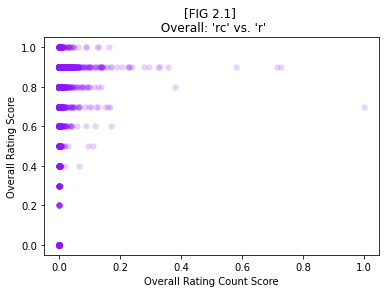

In [15]:
x = apple_final['overall_rc']
y = apple_final['overall_r']
plt.scatter(x, y, c='#8f15ff', alpha=0.2, linewidths=0.1)
plt.xlabel("Overall Rating Count Score")
plt.ylabel("Overall Rating Score")
plt.title("[FIG 2.1] \n Overall: 'rc' vs. 'r'")
plt.show()

In [16]:
apple_final['overall_score'] = (apple_final['overall_rc'] * weight_rc) + (apple_final['overall_r'] * weight_r)

In [17]:
apple_final['overall_score'].describe()

count    3222.000000
mean        0.467398
std         0.132835
min         0.000000
25%         0.421546
50%         0.488432
75%         0.540742
max         0.830661
Name: overall_score, dtype: float64

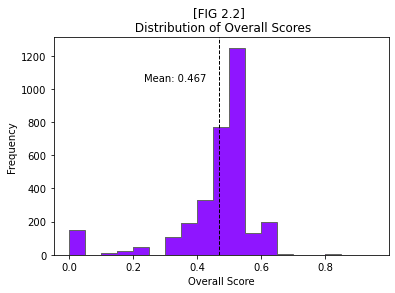

In [18]:
overall_scores = apple_final['overall_score']
plt.hist(overall_scores, 
         histtype='barstacked',
         bins=np.arange(0, 1, 0.05), 
         color='#8f15ff')
plt.hist(overall_scores, 
         histtype='step',
         bins=np.arange(0, 1, 0.05), 
         color='#656565')
plt.xlabel('Overall Score')
plt.ylabel('Frequency')
plt.title("[FIG 2.2] \n Distribution of Overall Scores")
plt.axvline(overall_scores.mean(), 
            color='k', 
            linestyle='dashed', 
            linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(x=overall_scores.mean()*0.5, 
         y=max_ylim*0.8, 
         s='Mean: {:.3f}'.format(overall_scores.mean()))
plt.show()

### GENRE SCORE
---

In [19]:
genre_unique = apple_final['genre'].unique()

In [20]:
apple_final['genre_rc'] = np.nan
apple_final['genre_r'] = np.nan
apple_final.head()

,app_name,genre,size_bytes,rating_count,rating,overall_rc,overall_r,overall_score,genre_rc,genre_r
0,Facebook,Social Networking,389879808,2974676,3.5,1.000000,0.7,0.820000,NaN,NaN
1,Instagram,Photo & Video,113954816,2161558,4.5,0.726653,0.9,0.830661,NaN,NaN
2,Clash of Clans,Games,116476928,2130805,4.5,0.716315,0.9,0.826526,NaN,NaN
3,Temple Run,Games,65921024,1724546,4.5,0.579742,0.9,0.771897,NaN,NaN
4,Pandora - Music & Radio,Music,130242560,1126879,4.0,0.378824,0.8,0.631530,NaN,NaN


In [21]:
for g in genre_unique:
    # Assigning the score values for 'rc'
    max_rc = apple_final.loc[apple_final['genre'] == g, 'rating_count'].max()
    min_rc = apple_final.loc[apple_final['genre'] == g, 'rating_count'].min()
    apple_final.loc[apple_final['genre'] == g, 'genre_rc'] = (apple_final.loc[apple_final['genre'] == g, 'rating_count'] - min_rc) / (max_rc - min_rc)
    # Assigning the score values for 'r'
    max_r = apple_final.loc[apple_final['genre'] == g, 'rating'].max()
    min_r = apple_final.loc[apple_final['genre'] == g, 'rating'].min()
    apple_final.loc[apple_final['genre'] == g, 'genre_r'] = (apple_final.loc[apple_final['genre'] == g, 'rating'] - min_r) / (max_r - min_r)

In [22]:
apple_final.head()

,app_name,genre,size_bytes,rating_count,rating,overall_rc,overall_r,overall_score,genre_rc,genre_r
0,Facebook,Social Networking,389879808,2974676,3.5,1.000000,0.7,0.820000,1.00000,0.700000
1,Instagram,Photo & Video,113954816,2161558,4.5,0.726653,0.9,0.830661,1.00000,0.900000
2,Clash of Clans,Games,116476928,2130805,4.5,0.716315,0.9,0.826526,1.00000,0.900000
3,Temple Run,Games,65921024,1724546,4.5,0.579742,0.9,0.771897,0.80934,0.900000
4,Pandora - Music & Radio,Music,130242560,1126879,4.0,0.378824,0.8,0.631530,1.00000,0.888889


In [23]:
apple_final[['genre_rc', 'genre_r']].isna().value_counts()

genre_rc  genre_r
False     False      3222
dtype: int64

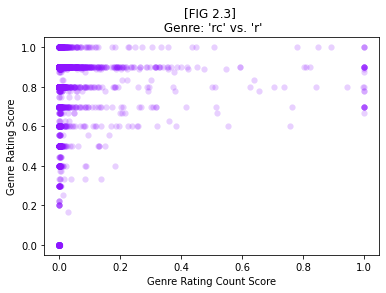

In [24]:
x = apple_final['genre_rc']
y = apple_final['genre_r']
plt.scatter(x, y, c='#8f15ff', alpha=0.2, linewidths=0.1)
plt.xlabel("Genre Rating Count Score")
plt.ylabel("Genre Rating Score")
plt.title("[FIG 2.3] \n Genre: 'rc' vs. 'r'")
plt.show()

In [25]:
apple_final['genre_score'] = (apple_final['genre_rc'] * weight_rc) + (apple_final['genre_r'] * weight_r)

In [26]:
apple_final['genre_score'].describe()

count    3222.000000
mean        0.477734
std         0.143952
min         0.000000
25%         0.450159
50%         0.540002
75%         0.542410
max         1.000000
Name: genre_score, dtype: float64

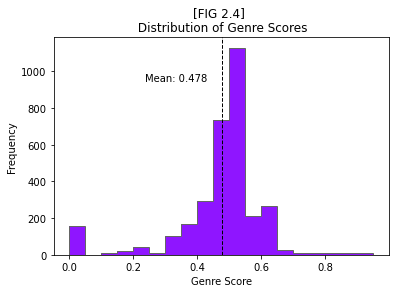

In [27]:
genre_scores = apple_final['genre_score']
plt.hist(genre_scores, 
         histtype='barstacked',
         bins=np.arange(0, 1, 0.05), 
         color='#8f15ff')
plt.hist(genre_scores, 
         histtype='step',
         bins=np.arange(0, 1, 0.05), 
         color='#656565')
plt.xlabel('Genre Score')
plt.ylabel('Frequency')
plt.title("[FIG 2.4] \n Distribution of Genre Scores")
plt.axvline(genre_scores.mean(), 
            color='k', 
            linestyle='dashed', 
            linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(x=genre_scores.mean()*0.5, 
         y=max_ylim*0.8, 
         s='Mean: {:.3f}'.format(genre_scores.mean()))
plt.show()

### SUCCESS SCORE
---

We came a long way already, and to recap what we did so far was to clean the data, and then come up with two types of scores. **Overall Score**, which evaluates each app with respect to all other apps; and **Genre Score** which evaluates each app with respect to other apps within the same genre.

To come up with these scores, the properties used were: "rating_count" and "rating" with the weights of <font color=purple>*40% and 60%*</font> respectively.

Now to gather these two scores into one and finally rank them, there is one more weighting system to be considered. After enough trial and error, the least biased way is to consider:
- **Overall Score**: 45%
- **Genre Score**: 55%

The reasoning behind comes back to the objective of this research, that is to produce an analysis capable of understanding the defining elements of an app's success. Success can be a relative concept:
- For most app creators being at the top of your own nieche (in this case, genre) is already a successful achievement.
- However also attracting highlights regardless of the nieche is also very well desired and hardly any developer is going to deny this chance.

> Yet, when it comes to the average app-maker, the first one already satisfy most of their needs, whilst the second is a bit more unrealistic. And for this reason there is a slight increse in the Genre Score weight.

In [28]:
weight_overall = 0.45
weight_genre = 0.55

In [29]:
print('This is a cut of our dataset to show what we have so far:')
apple_final[['app_name', 'genre', 'overall_score', 'genre_score']].head(10)

This is a cut of our dataset to show what we have so far:


,app_name,genre,overall_score,genre_score
0,Facebook,Social Networking,0.820000,0.820000
1,Instagram,Photo & Video,0.830661,0.940000
2,Clash of Clans,Games,0.826526,0.940000
3,Temple Run,Games,0.771897,0.863736
4,Pandora - Music & Radio,Music,0.631530,0.933333
5,Pinterest,Social Networking,0.682755,0.682755
6,Bible,Reference,0.672575,1.000000
7,Candy Crush Saga,Games,0.669331,0.720550
8,Spotify Music,Music,0.658139,0.911857
9,Angry Birds,Games,0.650863,0.694768


In [30]:
apple_final['success_score'] = (apple_final['overall_score'] * weight_overall) + (apple_final['genre_score'] * weight_genre)

In [31]:
apple_sorted = apple_final.sort_values('success_score', 
                                       ascending=False, 
                                       ignore_index=True)
print("And this is the Top 10 apps by Success Score:")
apple_sorted[['app_name', 'genre','success_score']].head(10)

And this is the Top 10 apps by Success Score:


,app_name,genre,success_score
0,Instagram,Photo & Video,0.890798
1,Clash of Clans,Games,0.888937
2,Bible,Reference,0.852659
3,Temple Run,Games,0.822408
4,CPlus for Craigslist app - mobile classifieds,Catalogs,0.820808
5,Facebook,Social Networking,0.820000
6,"Waze - GPS Navigation, Maps & Real-time Traffic",Navigation,0.813879
7,Domino's Pizza USA,Food & Drink,0.802900
8,Spotify Music,Music,0.797684
9,Pandora - Music & Radio,Music,0.797522


## 3. <font color=orange>Splitting Sample</font>
To define the borderline between Success & Failure we will:
- Visualize the Success Score distribution
- Defining criteria to create the borderlines
- Separate the datasets into two (success & failure)

In [32]:
apple_sorted['success_score'].describe()

count    3222.000000
mean        0.473082
std         0.137312
min         0.000000
25%         0.436976
50%         0.525697
75%         0.541773
max         0.890798
Name: success_score, dtype: float64

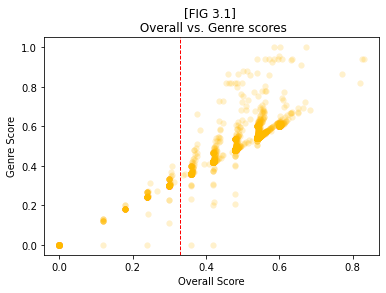

In [33]:
x = apple_sorted['overall_score']
y = apple_sorted['genre_score']
plt.scatter(x, y, c='#ffba00', alpha=0.2, linewidths=0.1)
plt.xlabel("Overall Score")
plt.ylabel("Genre Score")
plt.title("[FIG 3.1] \n Overall vs. Genre scores")
plt.axvline(0.33, 
            color='red', 
            linestyle='dashed', 
            linewidth=1)
plt.show()

*\[FIG 3.1\] It's observable that the <font color=red>red line</font> splits the apps with nearly same score for both Overall and Genre, from the apps in which these scores differs. That is an aspect we will be looking for to define the success borderline, apps which are not necessarily at the top of App Store's ranking, but **still lead their nieche (genre)** are going to be valuable for the outcome of this analysis.*

#### Understanding 'Success Score' blind spot
---

It called my attention that the visualizations from FIG 2.1 to FIG 3.1 weren't presenting that much of a difference. Even though we are double-counting the same criterias 'rc' and 'r' twice, I still believe joining them together adds value because it brings the 'within genre' relevance. However this raises a blind spot:

In [34]:
print('These are how many apps each genre has under it:')
apple_sorted['genre'].value_counts()

These are how many apps each genre has under it:


Games                1874
Entertainment         254
Photo & Video         160
Education             118
Social Networking     106
Shopping               84
Utilities              81
Sports                 69
Music                  66
Health & Fitness       65
Productivity           56
Lifestyle              51
News                   43
Travel                 40
Finance                36
Weather                28
Food & Drink           26
Reference              18
Business               17
Book                   14
Medical                 6
Navigation              6
Catalogs                4
Name: genre, dtype: int64

In [35]:
print('By looking at the genre with least apps:')
apple_sorted[apple_sorted['genre'] == 'Book']

By looking at the genre with least apps:


,app_name,genre,size_bytes,rating_count,rating,overall_rc,overall_r,overall_score,genre_rc,genre_r,genre_score,success_score
33,Color Therapy Adult Coloring Book for Adults,Book,135236608,84062,5.0,0.028259,1.0,0.611304,0.333479,1.0,0.733392,0.678452
49,"Kindle – Read eBooks, Magazines & Textbooks",Book,169747456,252076,3.5,0.084741,0.7,0.453896,1.000000,0.7,0.820000,0.655253
58,"Audible – audio books, original series & podcasts",Book,81558528,105274,4.5,0.035390,0.9,0.554156,0.417628,0.9,0.707051,0.638248
298,HOOKED - Chat Stories,Book,94545920,47829,4.5,0.016079,0.9,0.546431,0.189740,0.9,0.615896,0.584637
895,OverDrive – Library eBooks and Audiobooks,Book,39844864,65450,4.0,0.022002,0.8,0.488801,0.259644,0.8,0.583858,0.541082
1068,Dr. Seuss Treasury — 50 best kids books,Book,100943872,451,4.5,0.000152,0.9,0.540061,0.001789,0.9,0.540716,0.540421
1236,Weirdwood Manor,Book,342845440,197,4.5,0.000066,0.9,0.540026,0.000782,0.9,0.540313,0.540184
1557,MangaZERO - comic reader,Book,99365888,9,4.5,0.000003,0.9,0.540001,0.000036,0.9,0.540014,0.540008
1833,BookShout: Read eBooks & Track Your Reading Goals,Book,106071040,879,4.0,0.000295,0.8,0.480118,0.003487,0.8,0.481395,0.480820
1902,Green Riding Hood,Book,316589056,392,4.0,0.000132,0.8,0.480053,0.001555,0.8,0.480622,0.480366


It called my attention these two apps & it's respective scores:

| Success Rank| app_name | 'rc' | 'r' | overall_rc | overall_r | overall_score |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| 1557 | MangaZERO - comic reader | 9 | 4.5 | 0.000003 | 0.9 | 0.540001 |
| 1883 | BookShout: Read eBooks & Track Your Reading Goals | 879 | 4.0 | 0.000295 | 0.8 | 0.480118 |

The MangaZER0 App ended up with a Overall Score higher than the BookShout app, despite the fact that it has considerably less rating_count. This comes from 2 facts:
1. Minmax Feature Scaling is **very sensitive to the extreme outliers**
2. Considering the weighting system and **due to the low sample size** ('rc')

### **What is the blind spot then?**

Although these problems are real, they will only happen under specific circumstances:
- Genre with few apps
- App with few 'rc' but high 'r'

And by exploring the data-set this problem does not repeat very often, at least not in a way that it would affect the final objective of this analysis. Yet, with this in mind, our way forward is to make sure our success borderline doesn't include any apps that might be under this blind-spot.

> And the most effective way to ensure that, is to analyze the Successful Apps sample after creating the cut, and **ensuring that the 'rc' description (min, max, mean) are at an acceptable level** - no one can say an app with less than a hundred 'rc' is really successful, right?

In [36]:
success_cut = 200
min_rc = 1000

In [37]:
print("There are", apple_sorted['genre'].value_counts().shape[0], "genre in the full dataset.")

There are 23 genre in the full dataset.


In [38]:
print("By taking the Top {}, we still at least 1 app representative of all".format(str(success_cut)), apple_sorted['genre'].head(success_cut).value_counts().shape[0], "genres.")

By taking the Top 200, we still at least 1 app representative of all 23 genres.


In [39]:
print("Information about \"rating\":")
print(apple_sorted.loc[apple_sorted['rating_count'] >= min_rc, 'rating'].head(success_cut).describe())
print('\n')
print("Information about \"rating_count\":")
print(apple_sorted.loc[apple_sorted['rating_count'] >= min_rc, 'rating_count'].head(success_cut).describe())

Information about "rating":
count    200.000000
mean       4.715000
std        0.405707
min        3.500000
25%        4.500000
50%        5.000000
75%        5.000000
max        5.000000
Name: rating, dtype: float64


Information about "rating_count":
count    2.000000e+02
mean     1.935730e+05
std      3.739310e+05
min      1.104000e+03
25%      6.067250e+03
50%      4.212950e+04
75%      2.369048e+05
max      2.974676e+06
Name: rating_count, dtype: float64


In [40]:
apple_success = apple_sorted.copy()[apple_sorted['rating_count'] >= min_rc].head(success_cut)

Based on the information above, it's safe to define that our <font color=green>Success Bordeline</font> will be all Top 200 apps! Now what about the <font color=red>Failure Borderline</font>?

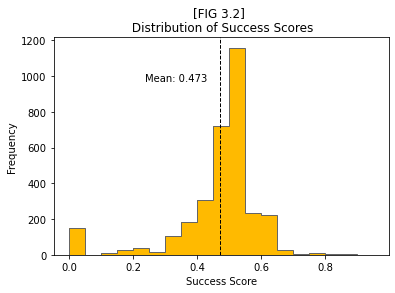

In [41]:
success_scores = apple_sorted['success_score']
plt.hist(success_scores, 
         histtype='barstacked',
         bins=np.arange(0, 1, 0.05), 
         color='#ffba00')
plt.hist(success_scores, 
         histtype='step',
         bins=np.arange(0, 1, 0.05), 
         color='#656565')
plt.xlabel('Success Score')
plt.ylabel('Frequency')
plt.title("[FIG 3.2] \n Distribution of Success Scores")
plt.axvline(success_scores.mean(), 
            color='k', 
            linestyle='dashed', 
            linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(x=success_scores.mean()*0.5, 
         y=max_ylim*0.8, 
         s='Mean: {:.3f}'.format(success_scores.mean()))
plt.show()

By looking at \[FIG 3.2\] it's clear how many apps are on the score 0, even after evaluating through the two lenses of Overall Apps and Genre Specific. It's then safe to assume that all that zero-segment should be in the failure borderline. The question is do we include some more?

In [42]:
print("A cut of our dataset including only apps who scored 0:")
apple_zero = apple_sorted.copy()[apple_sorted['success_score'] == 0]
apple_zero.describe()

A cut of our dataset including only apps who scored 0:


,size_bytes,rating_count,rating,overall_rc,overall_r,overall_score,genre_rc,genre_r,genre_score,success_score
count,1.510000e+02,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0,151.0
mean,8.265215e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,8.543434e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,2.441216e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,2.494362e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,5.141094e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,1.088031e+08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,4.691814e+08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
fail_score = 0.19

In [44]:
print("A cut of our dataset including only apps who scored more than zero and less than {}:".format(fail_score))
apple_fail_nonzero = apple_sorted.copy()[(apple_sorted['success_score'] > 0) & (apple_sorted['success_score'] < fail_score)]
apple_fail_nonzero.describe()

A cut of our dataset including only apps who scored more than zero and less than 0.19:


,size_bytes,rating_count,rating,overall_rc,overall_r,overall_score,genre_rc,genre_r,genre_score,success_score
count,3.200000e+01,32.000000,32.00000,3.200000e+01,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000
mean,6.776987e+07,217.218750,1.46875,7.302266e-05,0.293750,0.176279,0.000534,0.236458,0.142089,0.157474
std,9.712372e+07,426.000131,0.53788,1.432089e-04,0.107576,0.064551,0.001266,0.099830,0.059997,0.033656
min,4.448256e+06,1.000000,1.00000,3.361711e-07,0.200000,0.120000,0.000000,0.000000,0.000000,0.054000
25%,1.445990e+07,7.000000,1.00000,2.353197e-06,0.200000,0.120002,0.000003,0.200000,0.120001,0.125504
50%,4.596019e+07,28.500000,1.50000,9.580875e-06,0.300000,0.180004,0.000038,0.300000,0.180006,0.180006
75%,8.272589e+07,216.750000,1.50000,7.286508e-05,0.300000,0.180060,0.000256,0.300000,0.180060,0.180069
max,5.498470e+08,1999.000000,3.50000,6.720060e-04,0.700000,0.420029,0.005829,0.300000,0.182331,0.189013


In [45]:
apple_fail_nonzero[apple_fail_nonzero['rating_count'] > 1000]

,app_name,genre,size_bytes,rating_count,rating,overall_rc,overall_r,overall_score,genre_rc,genre_r,genre_score,success_score
3040,Philips Hue,Lifestyle,73561088,1999,1.5,0.000672,0.3,0.180269,0.005829,0.3,0.182331,0.181403
3041,Celebtwin: Celebrity Looks Like Lite,Lifestyle,81773568,1111,1.5,0.000373,0.3,0.180149,0.003239,0.3,0.181296,0.180780


The apps with score zero by itself already sum a total of 151, however so that we don't consider the score zero as the only criteria, we've done some analysis and it also makes sense to include apps with less than 0.19 success score, and the reason is:
- The rating is extremely low, averaging 1.47
- Only 2 apps with more than 1000 rating_count*

<div class="alert alert-block alert-info">
<b>(*)</b> This is relevant to bring up because when the fail_score was considered at 0.20 for example, the dataset contained many brands with many thousands in "rating_count", but they were low located due to the low "rating" - for example McDonalds App. Such brands are known regardless of their apps, and adding them into the Failure Borderline would affect the final analysis.
</div>

With that out of the way, our official <font color=red>Failure Borderline</font> Sample is going to consider apps with success scores ranging form **0 (inclusive) to 0.19 (exclusive)**.

In [46]:
apple_failure = pd.concat([apple_zero, apple_fail_nonzero])
apple_failure.sort_index(inplace=True)
apple_failure.head()

,app_name,genre,size_bytes,rating_count,rating,overall_rc,overall_r,overall_score,genre_rc,genre_r,genre_score,success_score
3039,Ringtone Remixes - Marimba Remix Ringtones,Catalogs,13437952,213,3.5,0.000072,0.7,0.420029,0.000000,0.0,0.000000,0.189013
3040,Philips Hue,Lifestyle,73561088,1999,1.5,0.000672,0.3,0.180269,0.005829,0.3,0.182331,0.181403
3041,Celebtwin: Celebrity Looks Like Lite,Lifestyle,81773568,1111,1.5,0.000373,0.3,0.180149,0.003239,0.3,0.181296,0.180780
3042,TestNav,Education,4448256,491,1.5,0.000165,0.3,0.180066,0.003018,0.3,0.181207,0.180694
3043,VyStar Mobile Banking for iPhone,Finance,27553792,434,1.5,0.000146,0.3,0.180058,0.001861,0.3,0.180744,0.180436


## 4. <font color=blue>Element's Evalutation</font>
Finding the correlation between the Success Score and the following elements:

- App's genre in comparision to other genres
- App's size in bytes
- App's name characteristics

### Genre Element
---

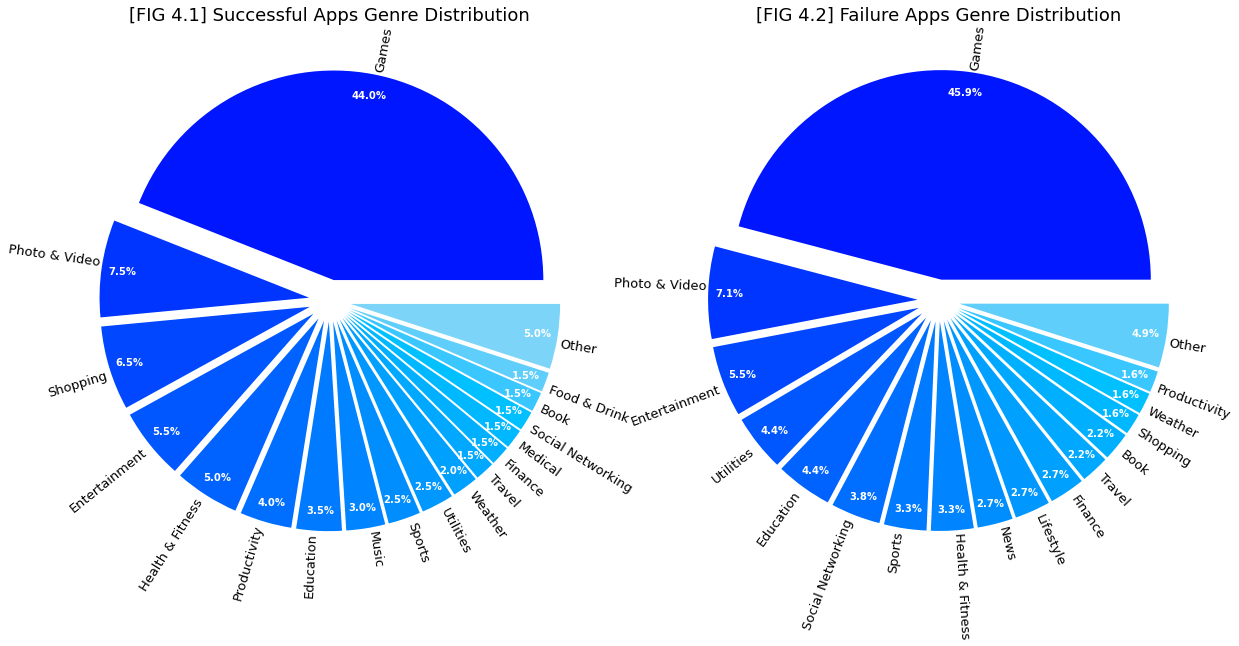

In [47]:
genre_dict_s = apple_success['genre'].value_counts().to_dict()
genre_dict_f = apple_failure['genre'].value_counts().to_dict()
genre_chart_s = {}
genre_chart_f = {}
threshold = 3

# Adding the genres in a dictionary, but grouping the ones under the threshold as 'Other'.
# First for Successful Apps, then to Failure Apps.
for key, group in itertools.groupby(genre_dict_s, lambda k: 'Other' if (genre_dict_s[k] < threshold) else k):
    genre_chart_s[key] = sum([genre_dict_s[k] for k in list(group)])
for key, group in itertools.groupby(genre_dict_f, lambda k: 'Other' if (genre_dict_f[k] < threshold) else k):
    genre_chart_f[key] = sum([genre_dict_f[k] for k in list(group)])

# Defining variables to use for the charts
labels_s = genre_chart_s.keys()
labels_f = genre_chart_f.keys()
sizes_s = genre_chart_s.values()
sizes_f = genre_chart_f.values()
explosion_s = np.full(len(sizes_s), 0.1)
explosion_f = np.full(len(sizes_f), 0.1)
colors = ['#0016ff', '#0034ff', '#0047ff', '#0056ff', '#0063ff', '#006fff', '#007aff', '#0084ff', '#008eff', '#0097ff', '#00a0ff', '#00a8ff', '#00b0ff', '#00b8ff', '#00c0ff', '#3ac7ff', '#60cefb', '#7cd5f8', '#95dbf5']

# Generating the 1 row 2 column chart grid
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

# Generating Success Apps chart
patches1, texts1, autotext1 = ax1.pie(sizes_s, 
                                      explode=explosion_s, 
                                      labels=labels_s, 
                                      colors=colors, 
                                      autopct='%1.1f%%', 
                                      pctdistance=0.9, 
                                      labeldistance=1.005, 
                                      startangle=0, 
                                      rotatelabels=True)
ax1.axis('equal')
# ax1.tight_layout()
ax1.set_title('[FIG 4.1] Successful Apps Genre Distribution', loc='center', fontsize=18)
for t in range(len(texts1)):
    texts1[t].set_fontsize(13)
    texts1[t].set_fontfamily('sans-serif')
    
for at in range(len(autotext1)):
    autotext1[at].set_fontsize(10)
    autotext1[at].set_fontfamily('sans-serif')
    autotext1[at].set_fontweight('bold')
    autotext1[at].set_color('white')

# Generating Failure Apps chart
patches2, texts2, autotext2 = ax2.pie(sizes_f, 
                                      explode=explosion_f, 
                                      labels=labels_f, 
                                      colors=colors, 
                                      autopct='%1.1f%%', 
                                      pctdistance=0.9, 
                                      labeldistance=1.005, 
                                      startangle=0, 
                                      rotatelabels=True)
ax2.axis('equal')
# ax2.tight_layout()
ax2.set_title('[FIG 4.2] Failure Apps Genre Distribution', loc='center', fontsize=18)
for t in range(len(texts2)):
    texts2[t].set_fontsize(13)
    texts2[t].set_fontfamily('sans-serif')
    
for at in range(len(autotext2)):
    autotext2[at].set_fontsize(10)
    autotext2[at].set_fontfamily('sans-serif')
    autotext2[at].set_fontweight('bold')
    autotext2[at].set_color('white')

plt.show()

# Reference:
# https://datascience.stackexchange.com/a/71417

---
> Overall this element turned out not to be very revealing. Both Success & Failure datasets presented a similar conclusion with **Games** genre at the top, concluding by looking at this element, we are non less than looking at the whole population's sample and the Success Score has no correlation to genre.

### App Size Element
---

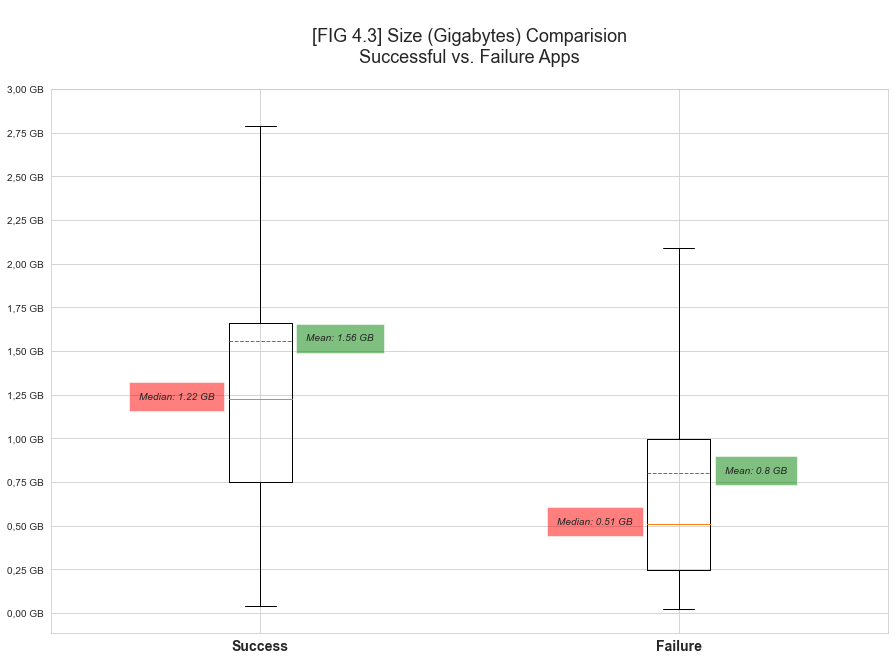

In [48]:
s = apple_success['size_bytes']
f = apple_failure['size_bytes']
locs = [0, 25000000, 50000000, 75000000, 100000000, 125000000, 150000000, 175000000, 200000000, 225000000, 250000000, 275000000, 300000000]
labs = ['0,00 GB', '0,25 GB', '0,50 GB', '0,75 GB', '1,00 GB', '1,25 GB', '1,50 GB', '1,75 GB', '2,00 GB', '2,25 GB', '2,50 GB', '2,75 GB', '3,00 GB']

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(15,10))
ax.boxplot((s, f), meanline=True, showfliers=False, widths=0.15, showmeans=True)
ax.ticklabel_format(style='plain', axis='y')
ax.set_title("\n[FIG 4.3] Size (Gigabytes) Comparision\nSuccessful vs. Failure Apps\n", fontsize=18)
ax.set_yticks(locs)
ax.set_yticklabels(labs)
ax.set_xticklabels(['Success', 'Failure'], fontsize=14, weight='bold')
ax.text(1.11, s.mean(), 'Mean: {}'.format(str(round(s.mean() / 100000000, 2)) + ' GB'), style='italic',
        bbox={'facecolor': 'green', 'alpha': 0.5, 'pad': 10})

ax.text(2.11, f.mean(), 'Mean: {}'.format(str(round(f.mean() / 100000000, 2)) + ' GB'), style='italic',
        bbox={'facecolor': 'green', 'alpha': 0.5, 'pad': 10})

ax.text(0.71, s.median(), 'Median: {}'.format(str(round(s.median() / 100000000, 2)) + ' GB'), style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})

ax.text(1.71, f.median(), 'Median: {}'.format(str(round(f.median() / 100000000, 2)) + ' GB'), style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})

plt.show()

---
For those unfamiliar to this type of chart, it basically shows the distribution of values to which the box represents the interquartiles (in simple words, the location where lies the middle 50% of all values) whereas the bottom and top lines represent the 0% and 100% respectively. By looking at quartiles we can understand our app's sample is distributed, and also compare it with the mean and median.

*Note: Outliers are not represented here.*

> The findings to this element are more clear and visual. More **successful apps tend to have a larger size** and thus intuitively we can understand that it also has more features. This can be relevant if developers sometimes are looking to create improving features but shun due to possibly increasing the app size. **As it seems, the users don't mind larger apps as long as its deliverying quality**.

### App Name Element
---

In [49]:
def count_words(string):
    no_symbols = re.sub(r'\s(.)\s', ' ', string)
    splitted = no_symbols.split()
    return len(splitted)

In [50]:
apple_success['app_name_length'] = apple_success['app_name'].apply(len)
apple_success['app_name_words'] = apple_success['app_name'].apply(count_words)
apple_success.iloc[:, [0, 1, 12, 13]].head()

,app_name,genre,app_name_length,app_name_words
0,Instagram,Photo & Video,9,1
1,Clash of Clans,Games,14,3
2,Bible,Reference,5,1
3,Temple Run,Games,10,2
4,CPlus for Craigslist app - mobile classifieds,Catalogs,45,6


In [51]:
apple_failure['app_name_length'] = apple_failure['app_name'].apply(len)
apple_failure['app_name_words'] = apple_failure['app_name'].apply(count_words)
apple_failure.iloc[:, [0, 1, 12, 13]].head()

,app_name,genre,app_name_length,app_name_words
3039,Ringtone Remixes - Marimba Remix Ringtones,Catalogs,42,5
3040,Philips Hue,Lifestyle,11,2
3041,Celebtwin: Celebrity Looks Like Lite,Lifestyle,36,5
3042,TestNav,Education,7,1
3043,VyStar Mobile Banking for iPhone,Finance,32,5


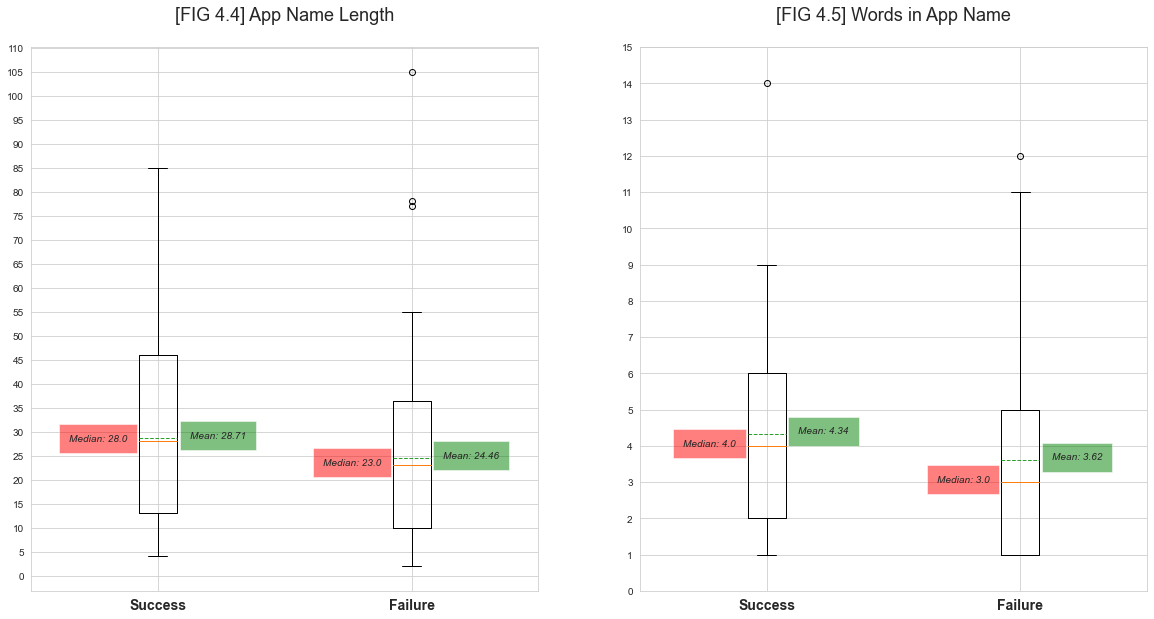

In [52]:
sns.set_style("whitegrid")
f_n_l = apple_failure['app_name_length']
s_n_l = apple_success['app_name_length']

f_n_w = apple_failure['app_name_words']
s_n_w = apple_success['app_name_words']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.boxplot((s_n_l, f_n_l), meanline=True, showfliers=True, showmeans=True)
ax1.ticklabel_format(style='plain', axis='y')
ax1.set_title("[FIG 4.4] App Name Length\n", fontsize=18)
ax1.set_yticks(range(0, 115, 5))
ax1.set_xticklabels(['Success', 'Failure'], fontsize=14, weight='bold')
ax1.text(1.125, s_n_l.mean(), 'Mean: {}'.format(str(round(s_n_l.mean(), 2))), style='italic',
        bbox={'facecolor': 'green', 'alpha': 0.5, 'pad': 10})

ax1.text(2.125, f_n_l.mean(), 'Mean: {}'.format(str(round(f_n_l.mean(), 2))), style='italic',
        bbox={'facecolor': 'green', 'alpha': 0.5, 'pad': 10})

ax1.text(0.65, s_n_l.median(), 'Median: {}'.format(str(round(s_n_l.median(), 2))), style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})

ax1.text(1.65, f_n_l.median(), 'Median: {}'.format(str(round(f_n_l.median(), 2))), style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})

ax2.boxplot((s_n_w, f_n_w), meanline=True, showfliers=True, showmeans=True)
ax2.ticklabel_format(style='plain', axis='y')
ax2.set_title("[FIG 4.5] Words in App Name\n", fontsize=18)
ax2.set_yticks(range(0, 16, 1))
ax2.set_xticklabels(['Success', 'Failure'], fontsize=14, weight='bold')
ax2.text(1.125, s_n_w.mean(), 'Mean: {}'.format(str(round(s_n_w.mean(), 2))), style='italic',
        bbox={'facecolor': 'green', 'alpha': 0.5, 'pad': 10})

ax2.text(2.125, f_n_w.mean(), 'Mean: {}'.format(str(round(f_n_w.mean(), 2))), style='italic',
        bbox={'facecolor': 'green', 'alpha': 0.5, 'pad': 10})

ax2.text(0.67, s_n_w.median(), 'Median: {}'.format(str(round(s_n_w.median(), 2))), style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})

ax2.text(1.67, f_n_w.median(), 'Median: {}'.format(str(round(f_n_w.median(), 2))), style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})

plt.show()

---
The same graph as explained before, but this time it includes outliers, that are values 1.5 times greater than the interquartile range limits (the limits are the values located at the borders of the quartiles 25% and 75%). You can see the outiers represented as small circles.

> I both charts the Success dataset tends to greater counts however, **considering the nature of this type of data, it's fair to consider this finding nearly irrelevant**. Yes, there's a tendency, but around 4 characters difference between Success and Failure datasets is not very significant considering that's a very small word, and less than 1 word difference for the second chart also seems to me insignificant.

## 5. <font color=green>Conclusion</font>
The detailed information used to reach these conclusions is in the previous stage of Elements Analysis. Here you will find:

- <font color=green>In green</font>: Conclusive insights found from the analysis
- <font color=orange>In yellow</font>: Inconclusive insights also found (sometimes not finding something is also finding)

<div class="alert alert-block alert-success">
<b>Focus on quality features, even if it takes more bytes:</b> The analysis has shown in [FIG 4.3] that more successful apps tend to be larger in size, and they are qualified as successful exactly because of a good customer feedback (count of ratings and average of ratings itself). With that, its very safe to assume that large apps are not a downside to have successful apps as long as they ensure quality.
</div>

<div class="alert alert-block alert-success">
<b>App name length or word count doesn't matter:</b> This is the perfect example where a 'no-finding' turned out as a 'finding'. The [FIG 4.4] and [FIG 4.5] clearly shows nearly no relevant difference on analyzing app names. One can argue that our initial raw sample might've not been large enough to take a conclusion out of this, so yes there is still room to improve and point out metrics of deviation between one another, but for the purpose of this project the finding was this explained here.
</div>

<div class="alert alert-block alert-warning">
<b>There's no right or wrong genre to achieve success:</b> The best indicator for that can be found at [FIG 4.1] and [FIG 4.2] where it can clearly be seen that there's not much difference in terms of genres from the successful apps dataset, to the failure dataset. It's not yet conclusive, our initial raw data was a very small sample size if compared to the whole App Store, so it can still be something to investigate in larger samples.
</div>